In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 100,

    # saving settings for latex
    # https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
    # "pgf.texsystem": "pdflatex",
    # "font.family": "serif",
    # "text.usetex": True,
    # "pgf.rcfonts": False,
    })

%matplotlib inline

In [2]:
# load the dataset without the target feature
df = pd.read_csv("./data/data/data_cvd_clean_subset_nomeds.csv", index_col=0, decimal='.')
df = df.iloc[:, :-1]
# df.info()

### 1- Feature Clustering Using Correlation Matrix

In [86]:
corr = df.corr(method='pearson').abs()
threshold = 0.3
df_cluster = pd.DataFrame()

# for each column we sort the column's and get the top correlated columns by setting a threshold,
# and save the result in a df
for col_name in corr.columns:
    corr_col = corr[col_name].sort_values(ascending=False)
    corr_col = corr_col[corr_col >= threshold]
    
    corr_series = pd.DataFrame([",".join(corr_col.index.values)], index=[col_name], columns=["correlated_columns"])
    df_cluster = df_cluster.append(corr_series)
    # print(corr_series.index.values[0])
    # print(corr_series.values[0][0])
    # print("\n")

# df_cluster.to_csv(f"data/data/features_clustering/feat_cluster_{threshold}.csv")
df_cluster.head()

,correlated_columns
Age (1),Age (1)
Gender (Male = 1),"Gender (Male = 1),HDL"
Angina,"Angina,Documented resting \nor exertional isch..."
Previous CABG,Previous CABG
Previous PCI,"Previous PCI,Previous \nMyocardial Infarction,CAD"


Correlation (>= 0.3) size: 63.0 / 3080


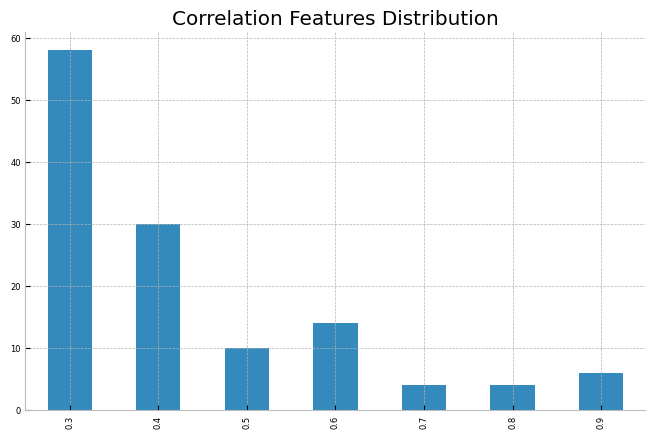

In [87]:
corr1D = pd.Series(corr.values.flatten())
corr1D = corr1D[corr1D != 1]
corr1D = corr1D.map(lambda x: round(x, 1))
corr_dist = corr1D.value_counts().sort_index()
corr_dist = corr_dist[corr_dist.index >= threshold]
corr_dist.plot(kind="bar", fontsize=6)
plt.title("Correlation Features Distribution")

print(f"Correlation (>= {threshold}) size: {corr_dist[corr_dist.index >= threshold].sum()/2} / {len(corr1D/2)}")

### 2- Feature Clustering Using Correlation Matrix + Hierarchical Clustering
https://stackoverflow.com/questions/38070478/how-to-do-clustering-using-the-matrix-of-correlation-coefficients

Number of clusters: 18


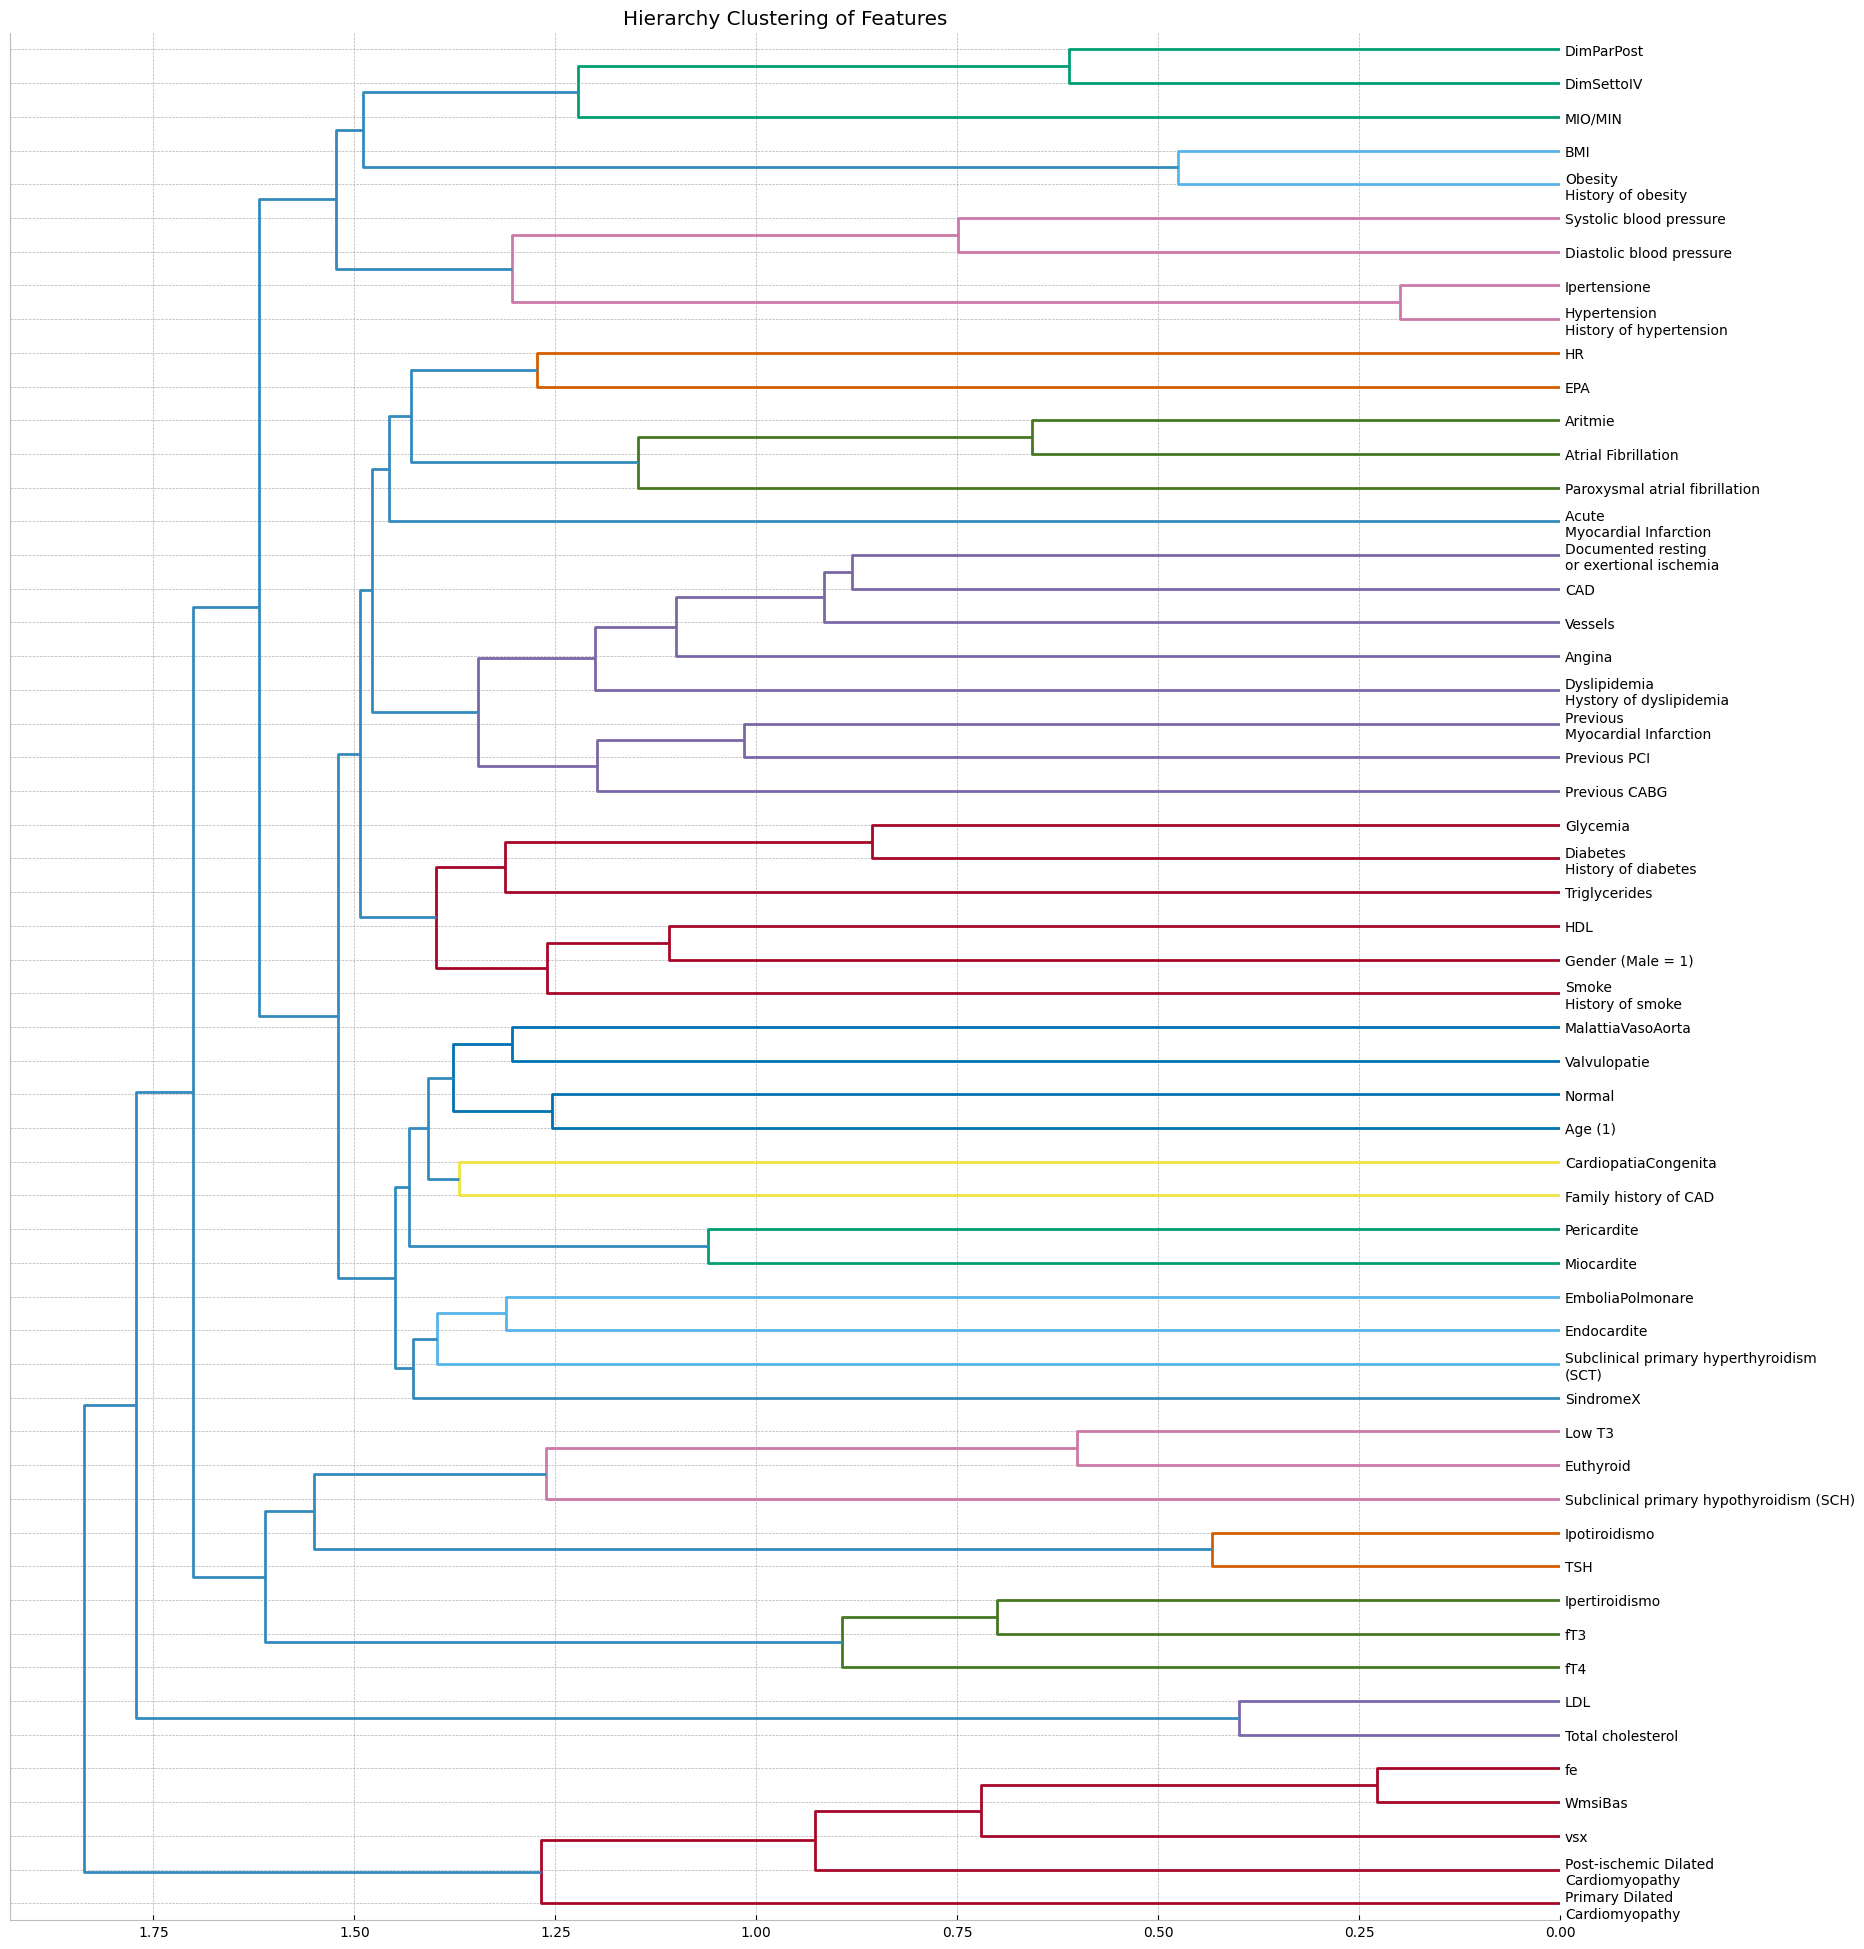

In [89]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# 1) compute the correlation (similarity) and distance (dissimilarity)
# TODO try spearman 
corr = df.corr(method='pearson')  
dist = 1 - corr.abs()

# 2) transform the distance matrix into a condensed distance vector
dist_condense = pdist(dist)

# 3) create the hierarchical clustering using the condensend distance vector
hier = hierarchy.linkage(dist_condense, method="weighted")
threshold = 1.4
# threshold = 1.5
cluster_labels = hierarchy.fcluster(hier, threshold, criterion="distance")
print(f"Number of clusters: {len(set(cluster_labels))}")

# plot
# choose threshold using dendrogram or any other method (e.g. quantile or desired number of features)
plt.figure(figsize=(20,25))
plt.title("Hierarchy Clustering of Features")
dend = hierarchy.dendrogram(hier, truncate_mode="level", p=30, color_threshold=threshold, 
                     labels=corr.columns, orientation="left", leaf_font_size=10)

In [121]:
# save each group feature
df_cluster = pd.DataFrame({'ClusterID': cluster_labels,
                           'Feature': df.columns})
df_cluster = df_cluster.groupby(['ClusterID'])
df_cluster = df_cluster['Feature'].apply(lambda x: list(x)).reset_index()['Feature']
df_cluster.to_pickle('data/data/features_clustering/feat_cluster_hier.df')
df_cluster

0     [Post-ischemic Dilated\nCardiomyopathy, Primar...
1                              [Total cholesterol, LDL]
2                            [fT3, fT4, Ipertiroidismo]
3                                  [TSH, Ipotiroidismo]
4     [Euthyroid, Subclinical primary hypothyroidism...
5     [Subclinical primary hyperthyroidism\n(SCT), E...
6                                           [SindromeX]
7                             [Miocardite, Pericardite]
8         [Family history of CAD, CardiopatiaCongenita]
9     [Age (1), Normal, Valvulopatie, MalattiaVasoAo...
10    [Gender (Male = 1), Smoke\nHistory of smoke, D...
11    [Angina, Previous CABG, Previous PCI, Previous...
12    [Atrial Fibrillation, Paroxysmal atrial fibril...
13                                            [EPA, HR]
14                      [Acute \nMyocardial Infarction]
15    [Hypertension\nHistory of hypertension, Iperte...
16                   [Obesity\nHistory of obesity, BMI]
17                    [MIO/MIN, DimSettoIV, DimP

In [130]:
df_test = pd.read_pickle('data/data/features_clustering/feat_cluster_hier.df')

In [6]:
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import silhouette_score

# cophenet correlation measure how faithfully the dendrogram preserves the original data point's distance
# cophenet is optimal when -> 1
# https://en.wikipedia.org/wiki/Cophenetic_correlation
c, coph_dists = cophenet(hier, pdist(dist))
c

0.7830776102820415

In [ ]:
# sns.clustermap(df.corr())
# plt.show()